# Synthetic control with sci-kit learn models

In [1]:
import causalpy as cp

## Load data

In [2]:
df = cp.load_data("sc")
treatment_time = 70

## Analyse with `WeightedProportion` model

In [3]:
result = cp.SyntheticControl(
    df,
    treatment_time,
    control_units=["a", "b", "c", "d", "e", "f", "g"],
    treated_units=["actual"],
    model=cp.skl_models.WeightedProportion(),
)

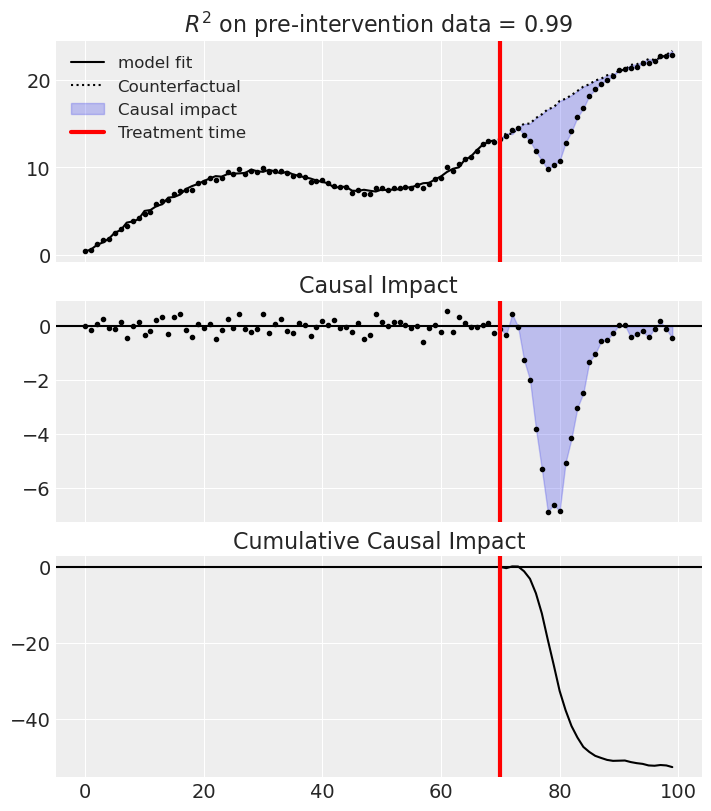

In [4]:
fig, ax = result.plot(plot_predictors=True)

In [5]:
result.summary(round_to=3)

================================SyntheticControl================================
Control units: ['a', 'b', 'c', 'd', 'e', 'f', 'g']
Treated unit: actual
Model coefficients:
  a	     0.319
  b	    0.0597
  c	     0.294
  d	    0.0605
  e	  0.000762
  f	     0.234
  g	    0.0321


But we can see that (for this dataset) these estimates are quite bad. So we can lift the "sum to 1" assumption and instead use the `LinearRegression` model, but still constrain weights to be positive. Equally, you could experiment with the `Ridge` model (e.g. `Ridge(positive=True, alpha=100)`).